In [2]:
#Importss

import os
import numpy as np
import cv2
from random import randint
import matplotlib.pyplot as plt

from PIL import Image

import torch

import torchvision.transforms as transforms
import numpy as np

import models
import dataprep
import evalmetrics
import torch.nn as nn
import custom_dataset

from torch.utils.data import Dataset, DataLoader, random_split, Subset

In [3]:
torch.cuda.is_available()

True

In [15]:
#Preparing Train Test and Validation Data

data_dir = 'SWED/train/'
full_dataset = custom_dataset.CustomDataset(data_dir)

start_index = 1000
end_index = 2000
subset_indices = range(start_index, end_index)
subset_dataset = Subset(full_dataset, subset_indices)


batch_size = None
my_dataloader = DataLoader(subset_dataset, batch_size=12, shuffle=True)

print(len(my_dataloader))

84


# Loading models

In [20]:
#For inference, we can still to cpu
device = torch.device("cpu")


################# Load EU-Net
checkpoint = torch.load('edgeunet_trained.pth',map_location=torch.device('cpu'))

# Create a new instance of your model
model_e = models.EdgeU1_Net(img_ch=3,output_ch=1)
model_e.to(device)

# Load the model state from the checkpoint
model_e.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state from the checkpoint, if needed
optimizer_e = torch.optim.Adam(model_e.parameters())
optimizer_e.load_state_dict(checkpoint['optimizer_state_dict'])

model_e.to(device)
model_e.eval() 

################# Load AU-Net
checkpoint = torch.load('aunet_trained.pth',map_location=torch.device('cpu'))

# Create a new instance of your model
model_a = models.AttU_Net(img_ch=3,output_ch=1)
model_a.to(device)

# Load the model state from the checkpoint
model_a.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state from the checkpoint, if needed
optimizer_a = torch.optim.Adam(model_a.parameters())
optimizer_a.load_state_dict(checkpoint['optimizer_state_dict'])

model_a.to(device)
model_a.eval()

################# Load U-Net
checkpoint = torch.load('unet_trained.pth',map_location=torch.device('cpu'))

# Create a new instance of your model
model_u = models.U_Net(img_ch=3,output_ch=1)
model_u.to(device)

# Load the model state from the checkpoint
model_u.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state from the checkpoint, if needed
optimizer_u = torch.optim.Adam(model_u.parameters())
optimizer_u.load_state_dict(checkpoint['optimizer_state_dict'])

model_u.to(device)
model_u.eval()

U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

In [26]:
#Picking a certain batch

for i, (images, labddels) in enumerate(my_dataloader):
    if i == 29:
        inputs,labels = images,labddels
        break

#Obtaining predictions from models
preds_u = model_u(inputs)
preds_a = model_a(inputs)
preds_e = model_e(inputs)

In [6]:
# A custom function to display tensors using imshow

def print_tensor(ten):
    r = ten[0]
    g = ten[1]
    b = ten[2]
    temp = np.ndarray(shape=(256,256,3), dtype=float)
    for j in range(256):
        for k in range(256):
            temp[j][k][0] = r[j][k]
            temp[j][k][1] = g[j][k]
            temp[j][k][2] = b[j][k]
    return temp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


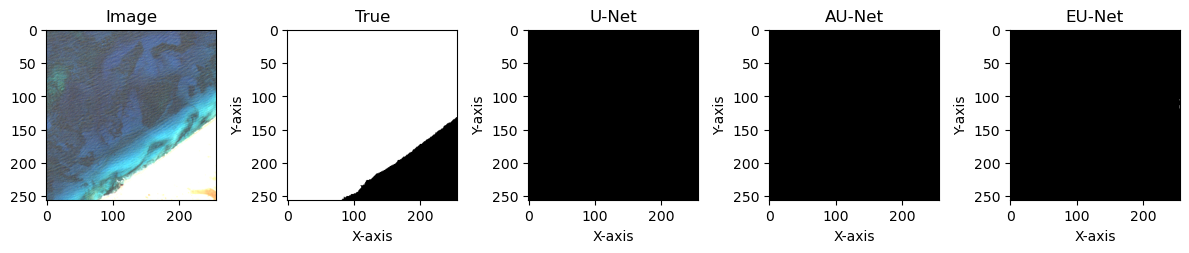

In [31]:
pic_indx = 2
#print_tensor(inputs[pic_indx]*1.9)

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(12, 4))

#True image
axs[0].imshow(print_tensor(inputs[pic_indx]*4))
axs[0].set_title('Image')

#True Label
temp_label = labels[pic_indx][0]
print(temp_label.shape)
x = temp_label
mask = torch.where(x > 0.5, torch.ones_like(x), torch.zeros_like(x))
axs[1].imshow(mask.detach().numpy(),cmap='gray')
axs[1].set_title("True")
axs[1].set_xlabel("X-axis")
axs[1].set_ylabel("Y-axis")


#U-Net
temp_label = preds_u[pic_indx][0]
print(temp_label.shape)
x = temp_label
mask = torch.where(x > 0.5, torch.ones_like(x), torch.zeros_like(x))
axs[2].imshow(mask.detach().numpy(),cmap='gray')
axs[2].set_title("U-Net")
axs[2].set_xlabel("X-axis")
axs[2].set_ylabel("Y-axis")

#U-Net
temp_label = preds_a[pic_indx][0]
print(temp_label.shape)
x = temp_label
mask = torch.where(x > 0.5, torch.ones_like(x), torch.zeros_like(x))
axs[3].imshow(mask.detach().numpy(),cmap='gray')
axs[3].set_title("AU-Net")
axs[3].set_xlabel("X-axis")
axs[3].set_ylabel("Y-axis")

#U-Net
temp_label = preds_e[pic_indx][0]
print(temp_label.shape)
x = temp_label
mask = torch.where(x > 0.5, torch.ones_like(x), torch.zeros_like(x))
axs[4].imshow(mask.detach().numpy(),cmap='gray')
axs[4].set_title("EU-Net")
axs[4].set_xlabel("X-axis")
axs[4].set_ylabel("Y-axis")

# Adjust layout and padding
plt.tight_layout()

# Show plot
plt.show()